<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/masked_addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://minpy.readthedocs.io/en/latest/tutorial/rnn_tutorial/rnn_tutorial.html

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
def adding_problem_generator(N, seq_len=6, high=1):
    # input --> label
    # 1 2 1 5 6  ---> 8 (2+6)
    # 0 1 0 0 1
    X_num = np.random.uniform(high=high, size=(N, seq_len, 1))
    X_mask = np.zeros(shape=(N, seq_len, 1))
    Y = np.zeros(shape=(N,1))
    for i in range(N):
        # choose 2 random positions to be set to 1
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    return np.concatenate((X_num, X_mask), axis=2), Y

In [6]:
N = 10000
T = 20
X_train, Y_train = adding_problem_generator(N, seq_len=T)

In [7]:
X_test, Y_test = adding_problem_generator(100, seq_len=T)

In [8]:
X_train[:1]

array([[[0.44534945, 0.        ],
        [0.93969555, 0.        ],
        [0.14100264, 0.        ],
        [0.6580253 , 1.        ],
        [0.40006553, 0.        ],
        [0.69936139, 0.        ],
        [0.59575999, 0.        ],
        [0.01143754, 0.        ],
        [0.98284187, 0.        ],
        [0.01437143, 0.        ],
        [0.75632976, 0.        ],
        [0.95300403, 0.        ],
        [0.81719167, 0.        ],
        [0.37187337, 0.        ],
        [0.77996038, 0.        ],
        [0.06913305, 0.        ],
        [0.46837773, 1.        ],
        [0.81418138, 0.        ],
        [0.23527873, 0.        ],
        [0.86899401, 0.        ]]])

In [9]:
Y_train[:1]

array([[1.12640303]])

In [10]:
X_test, Y_test = adding_problem_generator(N=10000, seq_len=T)

In [11]:
# baseline: always predict 1
baseline_mse = np.mean((Y_train-1)**2)

In [12]:
baseline_mse

0.16924092843415486

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

# Elman RNN

In [14]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          num_layers=1, 
                          nonlinearity='relu',
                          batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden=None):
        outputs, hidden = self.rnn(inputs, hidden)
        #print(f"RNN: {outputs.shape}, {hidden.shape}")
        #print(f"squeeze: {hidden.squeeze(0).shape}")
        output = self.linear(hidden.squeeze(0))
        #print(f"output: {output.shape}")
        return output
    

In [15]:
X_train_T = torch.from_numpy(X_train).float()
Y_train_T = torch.from_numpy(Y_train).float()
X_test_T = torch.from_numpy(X_test).float()
Y_test_T = torch.from_numpy(Y_test).float()

In [16]:
X_train_T.shape

torch.Size([10000, 20, 2])

In [17]:
%%time
model = ElmanRNN(input_size=2, hidden_size=100, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 100
data_len = X_train.shape[0]
n_epochs = 50
losses = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for start, end in zip(range(0, data_len+1, batch_size), 
                      range(batch_size, data_len+1, batch_size)):
        output = model(X_train_T[start:end]) # hidden is None

        optimizer.zero_grad()
        loss = criterion(output, Y_train_T[start:end])
        loss.backward()
        optimizer.step()
        
        losses[epoch] += loss.item()
        
    print("Epoch = {}, Loss = {}".format(epoch, losses[epoch]))

Epoch = 0, Loss = 24.650539457798004
Epoch = 1, Loss = 16.090579606592655
Epoch = 2, Loss = 12.5656100474298
Epoch = 3, Loss = 4.887838029302657
Epoch = 4, Loss = 1.6180782574228942
Epoch = 5, Loss = 0.9278192659839988
Epoch = 6, Loss = 0.6736499548424035
Epoch = 7, Loss = 0.48963710479438305
Epoch = 8, Loss = 0.3909674684982747
Epoch = 9, Loss = 0.3142716120928526
Epoch = 10, Loss = 0.2598282904946245
Epoch = 11, Loss = 0.20220626483205706
Epoch = 12, Loss = 0.16271785157732666
Epoch = 13, Loss = 0.13036638841731474
Epoch = 14, Loss = 0.09525943515473045
Epoch = 15, Loss = 0.08579839530284517
Epoch = 16, Loss = 0.07618388670380227
Epoch = 17, Loss = 0.056309833176783286
Epoch = 18, Loss = 0.057399347686441615
Epoch = 19, Loss = 0.05257714264735114
Epoch = 20, Loss = 0.05722430377500132
Epoch = 21, Loss = 0.06047577936260495
Epoch = 22, Loss = 0.053796206550032366
Epoch = 23, Loss = 0.05517552522360347
Epoch = 24, Loss = 0.05467094570485642
Epoch = 25, Loss = 0.055427302737371065
Epoch

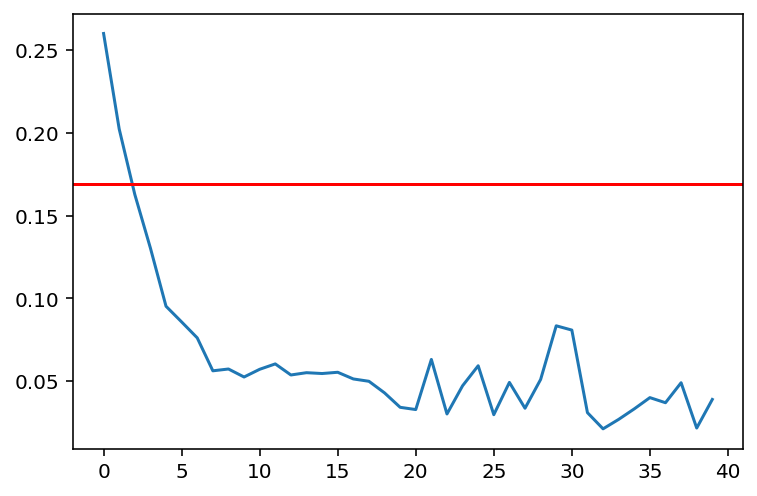

In [18]:
plt.plot(losses[10:])
plt.axhline(baseline_mse,color='r')

In [19]:
t = X_test_T[1:2,:,:]
t

tensor([[[0.0534, 0.0000],
         [0.0890, 0.0000],
         [0.3642, 0.0000],
         [0.8611, 0.0000],
         [0.0407, 0.0000],
         [0.0116, 0.0000],
         [0.9258, 0.0000],
         [0.6390, 0.0000],
         [0.0514, 0.0000],
         [0.0655, 0.0000],
         [0.6906, 0.0000],
         [0.7247, 0.0000],
         [0.2928, 0.0000],
         [0.1538, 1.0000],
         [0.8897, 0.0000],
         [0.7652, 0.0000],
         [0.1388, 1.0000],
         [0.2810, 0.0000],
         [0.8141, 0.0000],
         [0.9815, 0.0000]]])

In [20]:
model(t)

tensor([[0.3409]], grad_fn=<AddmmBackward>)

In [21]:
t[t[:,:,1]==1].sum(axis=0)

tensor([0.2926, 2.0000])